# Packages/ Imports

In [ ]:
'''
Update conda env using the following line in the /environment directory
    ` conda env update --file ml_portfolio_opt_env_<OS>.yml --prune `
'''

In [ ]:
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import yfinance as yf
import statsmodels
import pyfolio as pf

# Import libraries for ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from src.myarima import MyARIMA
from src.init_dataset import InitDataset
from src.mykmeans import MyKMeans
import src.utils as utils
from src.mptoptimizer import MPTOptimizer

print("Finished importing utils!")

In [3]:
import yfinance as yf
import pandas as pd


tickers = ['AAPL','GOOG','MSFT','AMZN','INTC','AMD','NVDA','F','TSLA', 'JPM','MS','VOO']

### Save tickers data in seperate files
for ticker in tickers:
    ticker_data = yf.Ticker(ticker)
    data = yf.download(ticker, start='2018-01-01', end='2023-12-31')
    df = pd.DataFrame(data)
    df['ticker'] = ticker
    df.to_csv(f'{ticker}_data.csv', index=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
import yfinance as yf
import pandas as pd
# Define datasets paths
# works in my computer,but not with repo.
datasets = [
    'dwu359/ml-portfolio-optimization/dataset/10yInterestrate_dataset.csv',
    'dwu359/ml-portfolio-optimization/dataset/GDP_dataset.csv',
    'dwu359/ml-portfolio-optimization/dataset/Median Consumer Price Index.csv',
    'dwu359/ml-portfolio-optimization/dataset/personal_saving_rate_dataset.csv',
    'dwu359/ml-portfolio-optimization/dataset/unemployed_dataset.csv'
]

# Create an empty DataFrame to store merged data
merged_df = pd.DataFrame({'DATE': pd.date_range(start='2018-01-01', end='2023-12-31', freq='MS')})
merged_df.set_index('DATE', inplace=True)

# Merge datasets based on 'DATE' column
for path in datasets:
    temp_df = pd.read_csv(path)
    temp_df['DATE'] = pd.to_datetime(temp_df['DATE'])
    temp_df.set_index('DATE', inplace=True)
    
    # Merge on 'DATE' column
    merged_df = pd.merge(merged_df, temp_df, left_index=True, right_index=True, how='left')

# Fill missing values with values from the previous month
merged_df.fillna(method='ffill', inplace=True)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('./dataset/econ_data.csv', index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'dwu359/ml-portfolio-optimization/dataset/10yInterestrate_dataset.csv'

DBScan

/Users/dwu/Documents/GitKraken/ml-portfolio-optimization


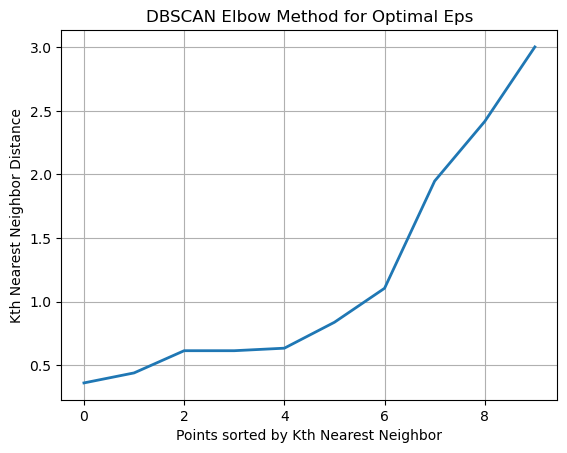

Clustering without PCA
Suggested Stocks without PCA for eps=1.25: ['NVDA', 'VOO']
Silhouette 0.7372882860712127
Davies Bouldin 0.31485440801750836
Calinski Harabasz 48.60133113481398


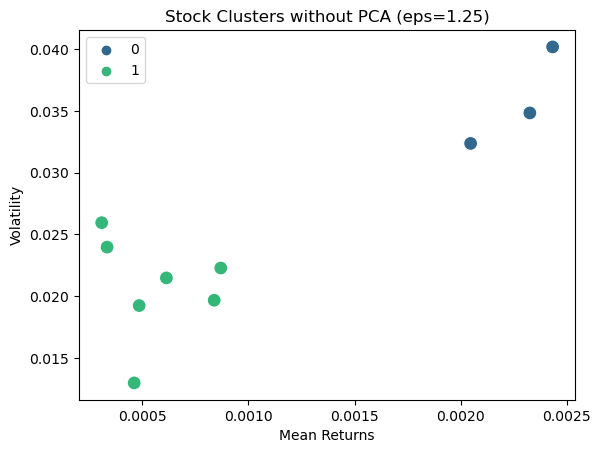

Suggested Stocks without PCA for eps=1.5: ['NVDA', 'VOO']
Silhouette 0.7372882860712127
Davies Bouldin 0.31485440801750836
Calinski Harabasz 48.60133113481398


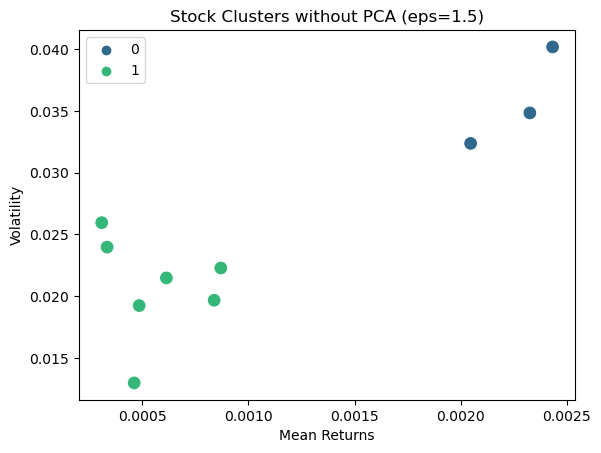

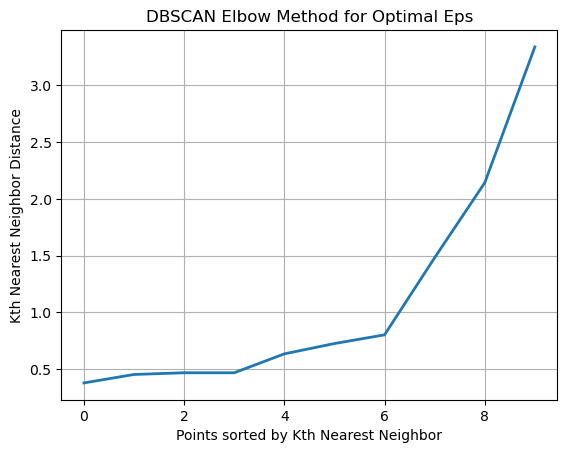

Clustering with PCA
Suggested Stocks with PCA for eps=0.75: ['NVDA', 'VOO']
Silhouette 0.49596518696457775
Davies Bouldin 1.0793167394555374
Calinski Harabasz 5.8266935648885685


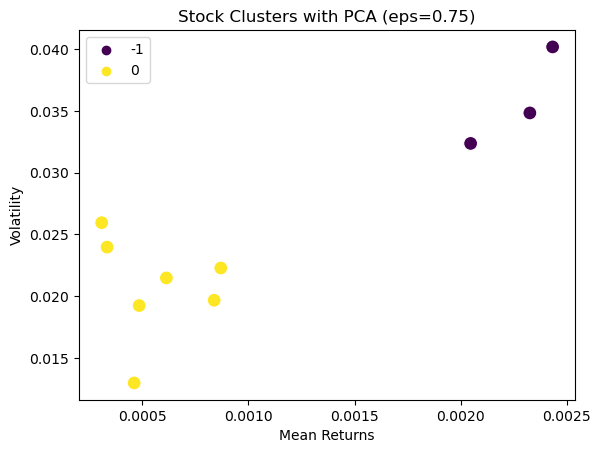

Suggested Stocks with PCA for eps=1.0: ['NVDA', 'VOO']
Silhouette 0.49596518696457775
Davies Bouldin 1.0793167394555374
Calinski Harabasz 5.8266935648885685


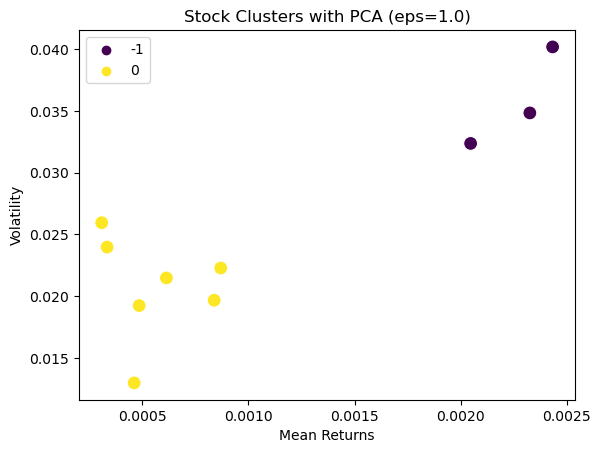

In [100]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

print(os.getcwd())

# Load the time series data from CSV files
stock_files = {
    'NVDA': 'NVDA_data.csv',
    'VOO': 'VOO_data.csv',
    'JPM': 'JPM_data.csv',
    'MS': 'MS_data.csv',
    'TSLA': 'TSLA_data.csv',
    'AMD': 'AMD_data.csv',
    'F': 'F_data.csv',
    'AMZN': 'AMZN_data.csv',
    'GOOG': 'GOOG_data.csv',
    'INTC': 'INTC_data.csv',
}

# Load and preprocess data
stock_symbols = list(stock_files.keys())
stock_data = {}

for symbol in stock_symbols:
    stock_data[symbol] = pd.read_csv('./dataset/' + symbol + '_data.csv', usecols=['Date', 'Close'])
    stock_data[symbol]['Date'] = pd.to_datetime(stock_data[symbol]['Date'])
    stock_data[symbol].set_index('Date', inplace=True)

# Align dataframes to the same date range and fill missing values
df_close = pd.DataFrame({symbol: data['Close'] for symbol, data in stock_data.items()})
df_close = df_close.fillna(method='ffill').dropna()

# Feature extraction
daily_returns = df_close.pct_change().dropna()
features = pd.DataFrame()
features['mean_returns'] = daily_returns.mean()
features['volatility'] = daily_returns.std()

# Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#Elbow plot
tree = BallTree(features_scaled, leaf_size=2)
k = 4
dist, _ = tree.query(features_scaled, k=k)
plt.plot(np.arange(features_scaled.shape[0]), np.sort(dist[:, k-1]), linewidth=2, markersize=5)
plt.xlabel("Points sorted by Kth Nearest Neighbor")
plt.ylabel("Kth Nearest Neighbor Distance")
plt.title("DBSCAN Elbow Method for Optimal Eps")
plt.grid(True)
plt.show()

# Metrics storage for both methods
metrics_without_pca = {'eps': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []}
metrics_with_pca = {'eps': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []}
#Clustering
print("Clustering without PCA")
range_n_clusters = np.arange(1.25, 1.75, 0.25)
for eps in range_n_clusters:
    dbscan = DBSCAN(eps=eps, min_samples=3)
    features['cluster'] = dbscan.fit_predict(features_scaled)
    # Evaluation metrics
    silhouette_avg = silhouette_score(features_scaled, features['cluster'])
    davies_bouldin = davies_bouldin_score(features_scaled, features['cluster'])
    calinski_harabasz = calinski_harabasz_score(features_scaled, features['cluster'])

    # Storing metrics
    metrics_without_pca['eps'].append(eps)
    metrics_without_pca['silhouette'].append(silhouette_avg)
    metrics_without_pca['davies_bouldin'].append(davies_bouldin)
    metrics_without_pca['calinski_harabasz'].append(calinski_harabasz)

    selected_stocks = features.groupby('cluster')['volatility'].idxmin().values.tolist()
    print(f"Suggested Stocks without PCA for eps={eps}: {selected_stocks}")
    print("Silhouette", metrics_without_pca['silhouette'][-1])
    print("Davies Bouldin", metrics_without_pca['davies_bouldin'][-1])
    print("Calinski Harabasz", metrics_without_pca['calinski_harabasz'][-1])


    # Plotting
    sns.scatterplot(data=features, x='mean_returns', y='volatility', hue='cluster', palette='viridis', s=100)
    plt.title(f'Stock Clusters without PCA (eps={eps})')
    plt.xlabel('Mean Returns')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

#With PCA
# PCA transformation
pca = PCA(n_components=2)
daily_returns_t = daily_returns.T
pca.fit(daily_returns_t)
daily_returns_pca = pca.transform(daily_returns_t)
features_pca = pd.DataFrame(daily_returns_pca, index=daily_returns.columns, columns=['PC1', 'PC2'])
features_pca_scaled = scaler.fit_transform(features_pca)

#Elbow plot
tree = BallTree(features_pca_scaled, leaf_size=2)
k = 4
dist, _ = tree.query(features_pca_scaled, k=k)
plt.plot(np.arange(features_pca_scaled.shape[0]), np.sort(dist[:, k-1]), linewidth=2, markersize=5)
plt.xlabel("Points sorted by Kth Nearest Neighbor")
plt.ylabel("Kth Nearest Neighbor Distance")
plt.title("DBSCAN Elbow Method for Optimal Eps")
plt.grid(True)
plt.show()

# Metrics storage for both methods
metrics_without_pca = {'eps': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []}
metrics_with_pca = {'eps': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []}
#Clustering
print("Clustering with PCA")
range_n_clusters = np.arange(0.75, 1.25, 0.25)
for eps in range_n_clusters:
    dbscan = DBSCAN(eps=eps, min_samples=3)
    features['cluster'] = dbscan.fit_predict(features_pca_scaled)
    # Evaluation metrics
    silhouette_avg = silhouette_score(features_pca_scaled, features['cluster'])
    davies_bouldin = davies_bouldin_score(features_pca_scaled, features['cluster'])
    calinski_harabasz = calinski_harabasz_score(features_pca_scaled, features['cluster'])

    # Storing metrics
    metrics_without_pca['eps'].append(eps)
    metrics_without_pca['silhouette'].append(silhouette_avg)
    metrics_without_pca['davies_bouldin'].append(davies_bouldin)
    metrics_without_pca['calinski_harabasz'].append(calinski_harabasz)

    selected_stocks = features.groupby('cluster')['volatility'].idxmin().values.tolist()
    print(f"Suggested Stocks with PCA for eps={eps}: {selected_stocks}")
    print("Silhouette", metrics_without_pca['silhouette'][-1])
    print("Davies Bouldin", metrics_without_pca['davies_bouldin'][-1])
    print("Calinski Harabasz", metrics_without_pca['calinski_harabasz'][-1])


    # Plotting
    sns.scatterplot(data=features, x='mean_returns', y='volatility', hue='cluster', palette='viridis', s=100)
    plt.title(f'Stock Clusters with PCA (eps={eps})')
    plt.xlabel('Mean Returns')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

# Data Management

/Users/dwu/Documents/GitKraken/ml-portfolio-optimization
Clustering without PCA
Suggested Stocks without PCA for k=3: ['JPM', 'NVDA', 'VOO']


/var/folders/lh/jxyzyr795kldsywmc1tt1f7r0000gn/T/ipykernel_55305/376227270.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_close = df_close.fillna(method='ffill').dropna()
/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


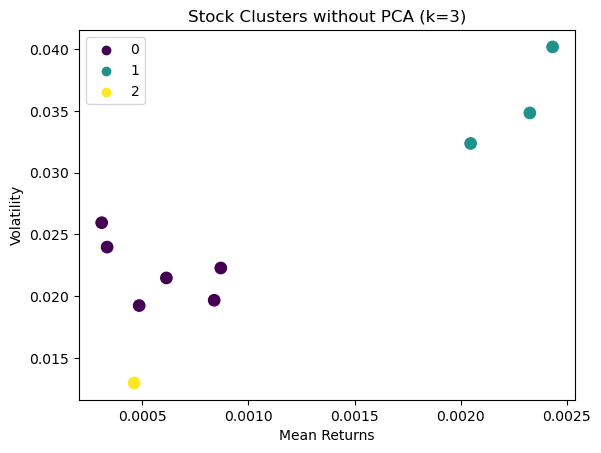

Suggested Stocks without PCA for k=4: ['JPM', 'NVDA', 'VOO', 'INTC']


/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


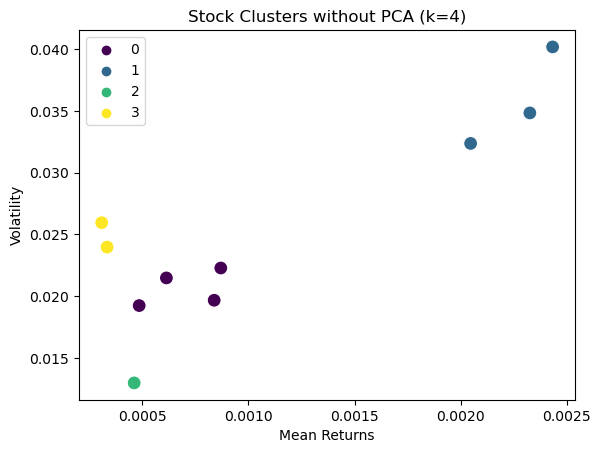

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks without PCA for k=5: ['JPM', 'NVDA', 'TSLA', 'INTC', 'VOO']


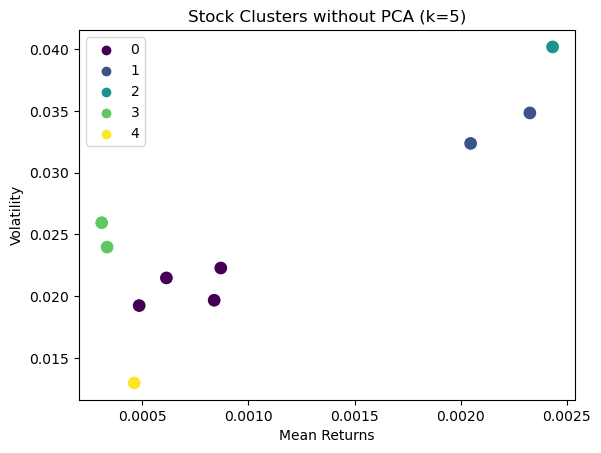

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks without PCA for k=6: ['JPM', 'NVDA', 'INTC', 'VOO', 'GOOG', 'TSLA']


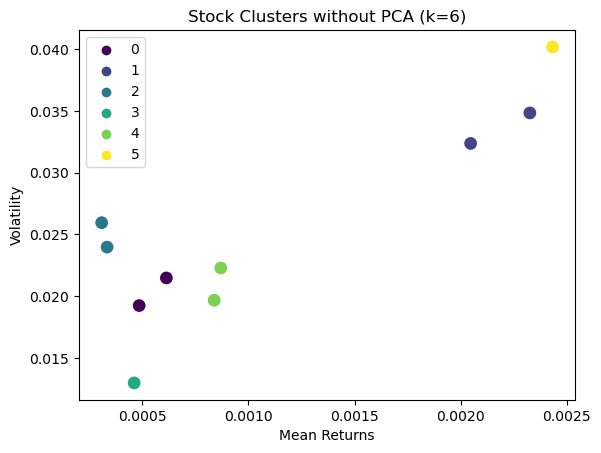

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks without PCA for k=7: ['JPM', 'AMD', 'VOO', 'INTC', 'NVDA', 'TSLA', 'GOOG']


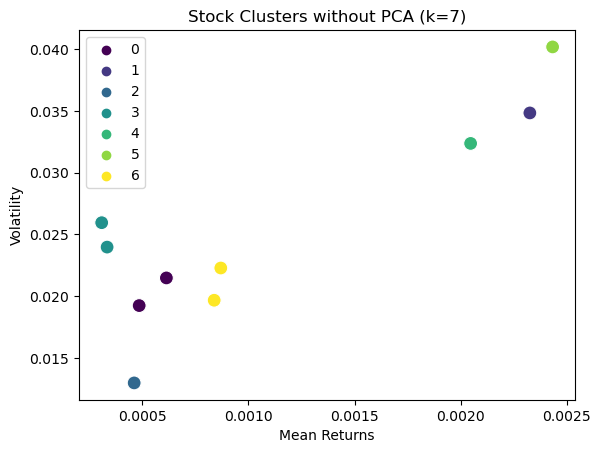

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks without PCA for k=8: ['JPM', 'AMD', 'VOO', 'INTC', 'TSLA', 'NVDA', 'AMZN', 'GOOG']


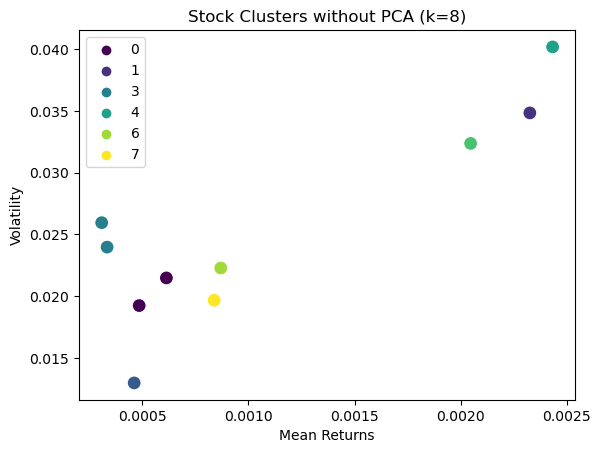

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks without PCA for k=9: ['MS', 'AMD', 'VOO', 'INTC', 'TSLA', 'NVDA', 'AMZN', 'GOOG', 'JPM']


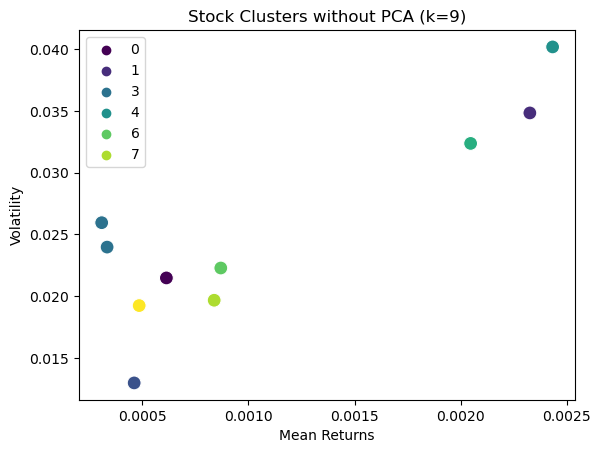

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Clustering with PCA
Suggested Stocks with PCA for k=3: ['VOO', 'NVDA', 'TSLA']


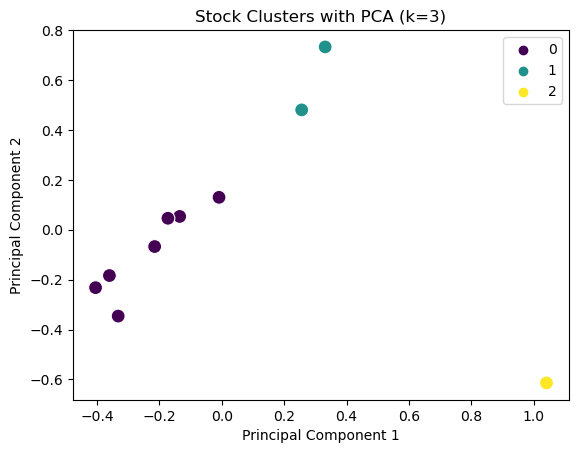

Suggested Stocks with PCA for k=4: ['NVDA', 'VOO', 'TSLA', 'JPM']


/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


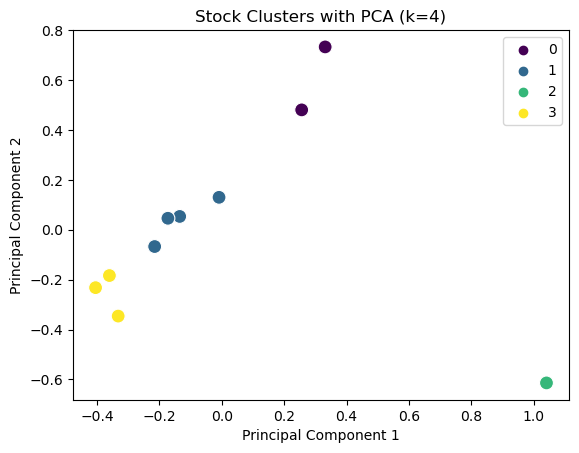

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks with PCA for k=5: ['JPM', 'NVDA', 'TSLA', 'VOO', 'AMD']


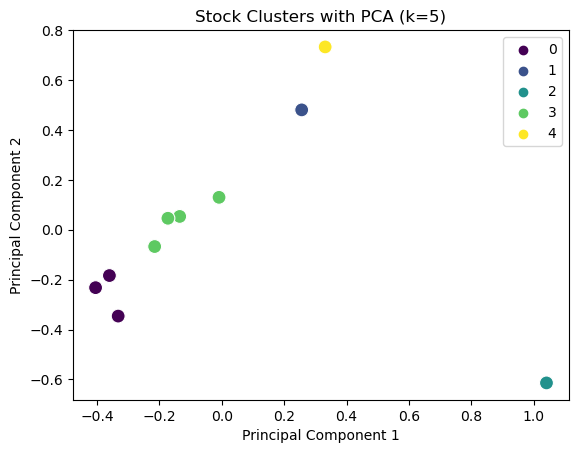

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks with PCA for k=6: ['NVDA', 'VOO', 'TSLA', 'JPM', 'AMD', 'AMZN']


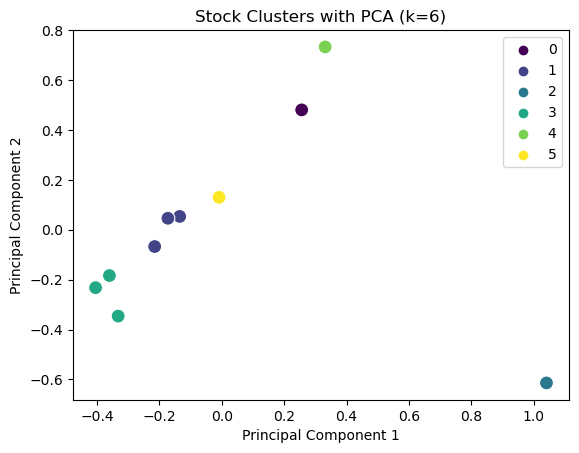

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks with PCA for k=7: ['F', 'NVDA', 'TSLA', 'VOO', 'AMD', 'AMZN', 'JPM']


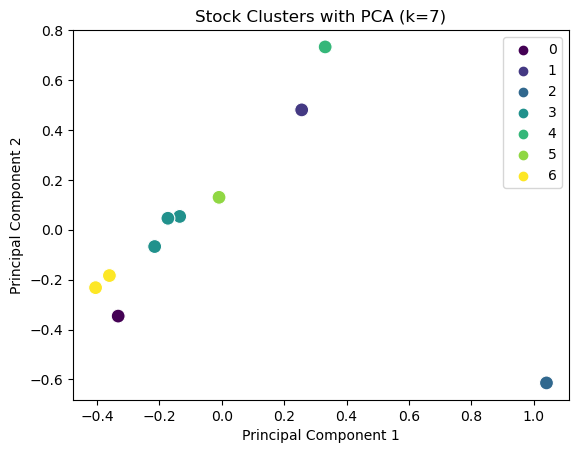

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks with PCA for k=8: ['JPM', 'AMZN', 'TSLA', 'AMD', 'NVDA', 'GOOG', 'F', 'VOO']


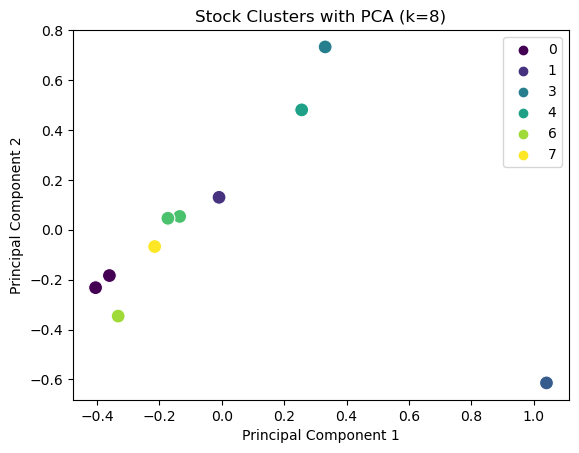

/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Suggested Stocks with PCA for k=9: ['MS', 'AMZN', 'TSLA', 'AMD', 'NVDA', 'GOOG', 'F', 'VOO', 'JPM']


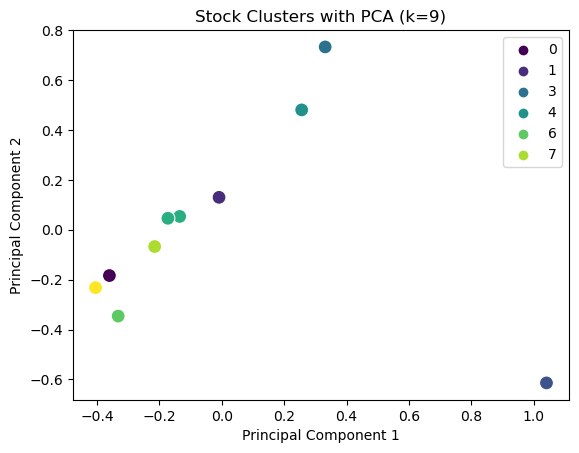

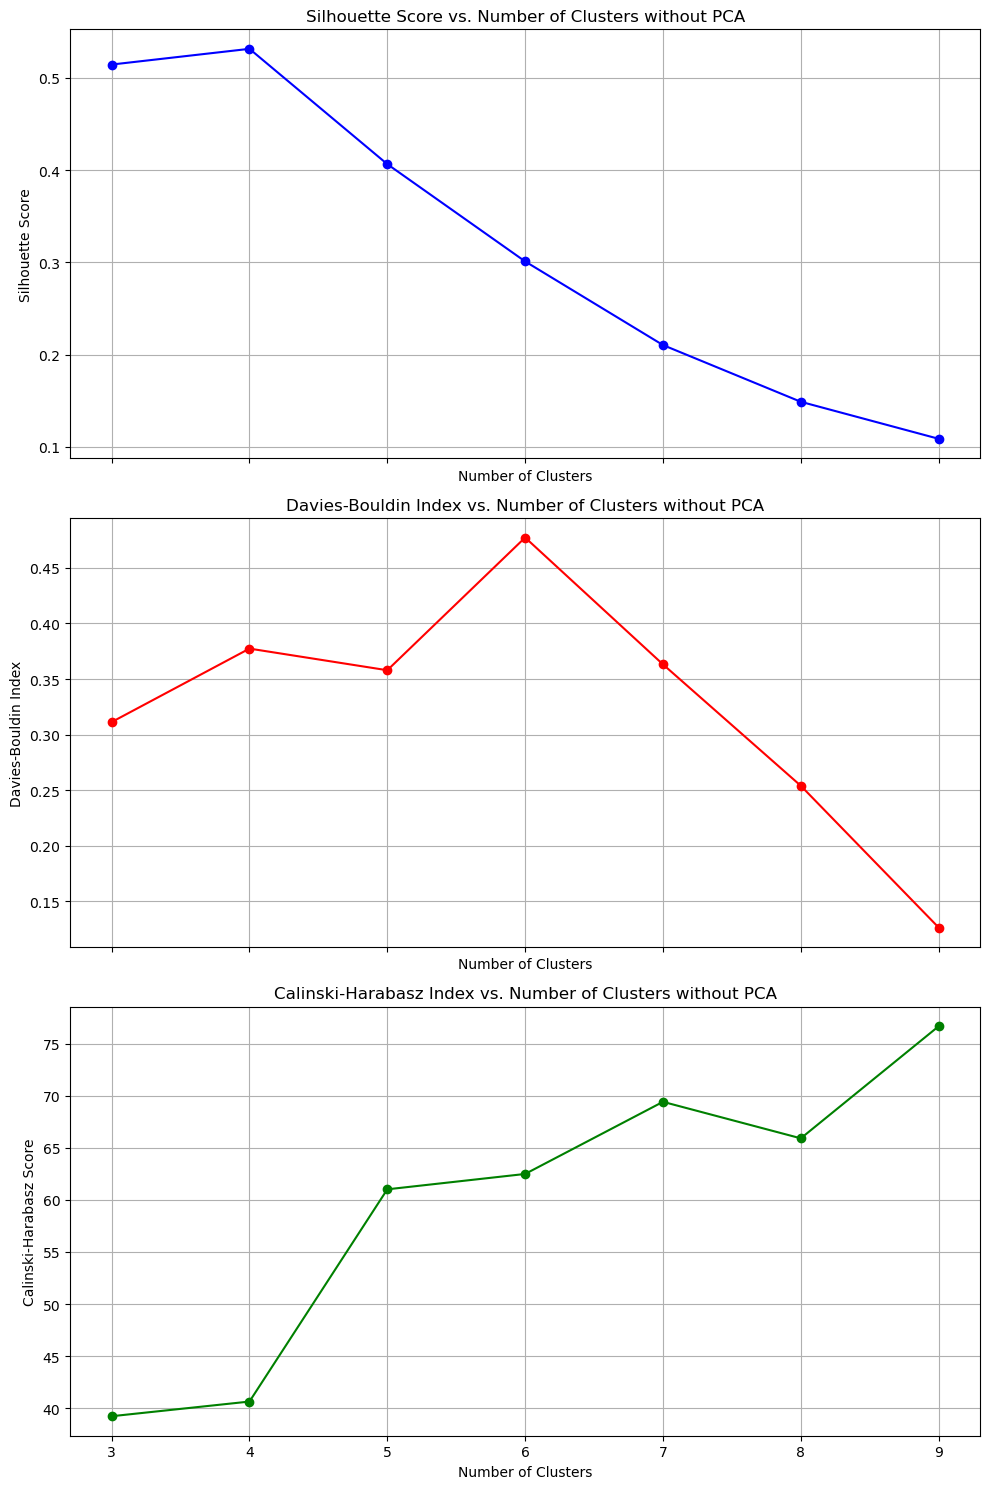

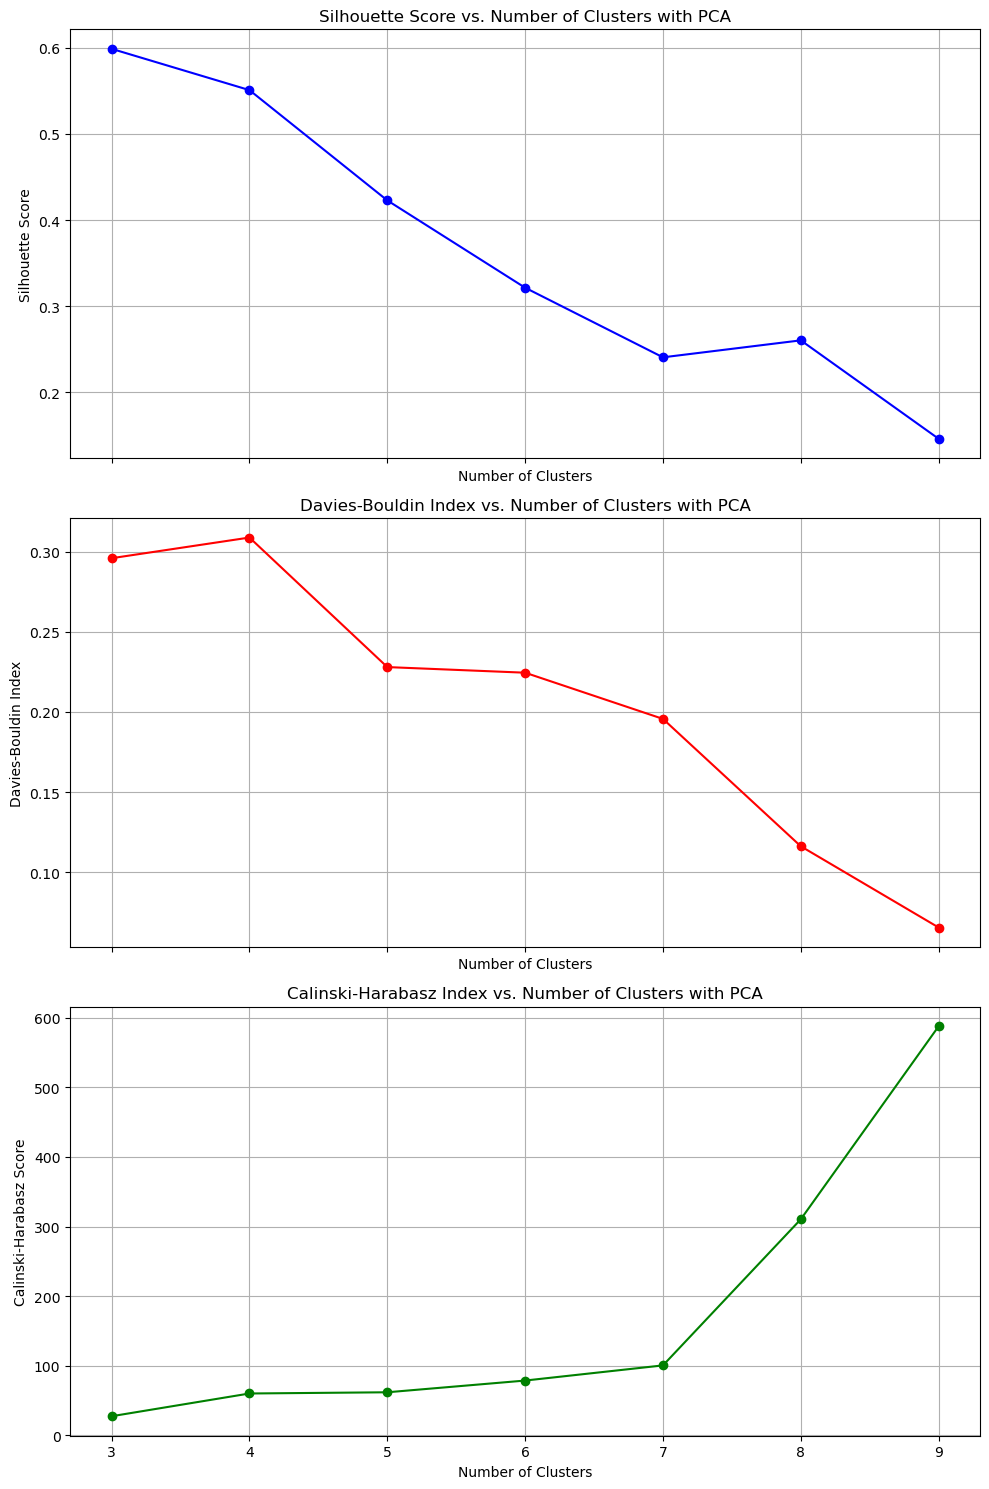

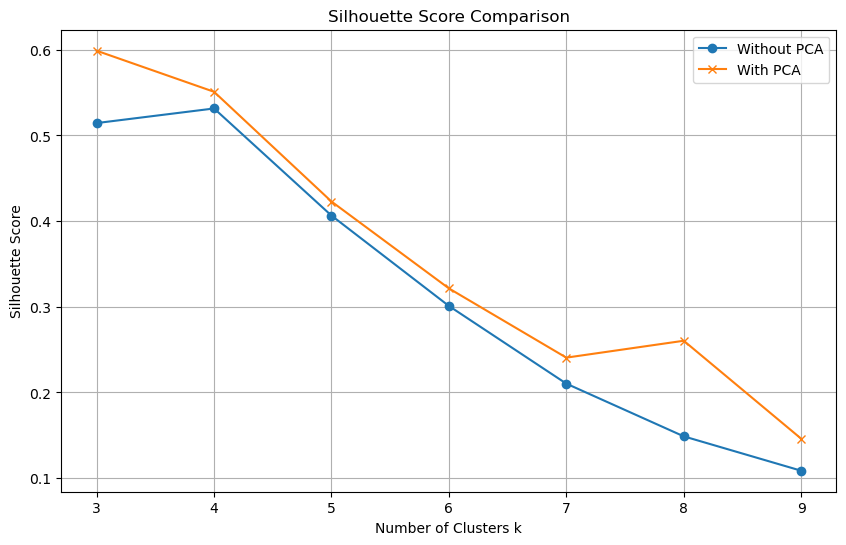

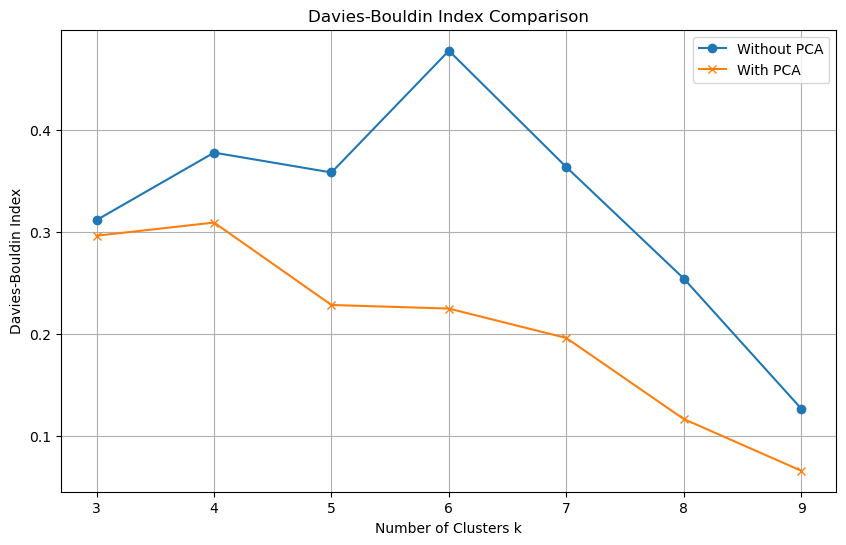

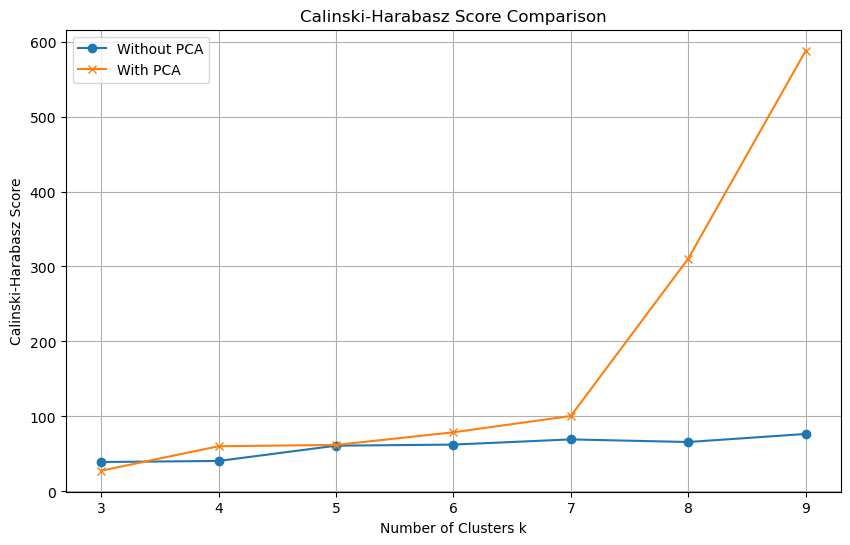

Elbow Method without PCA


/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1

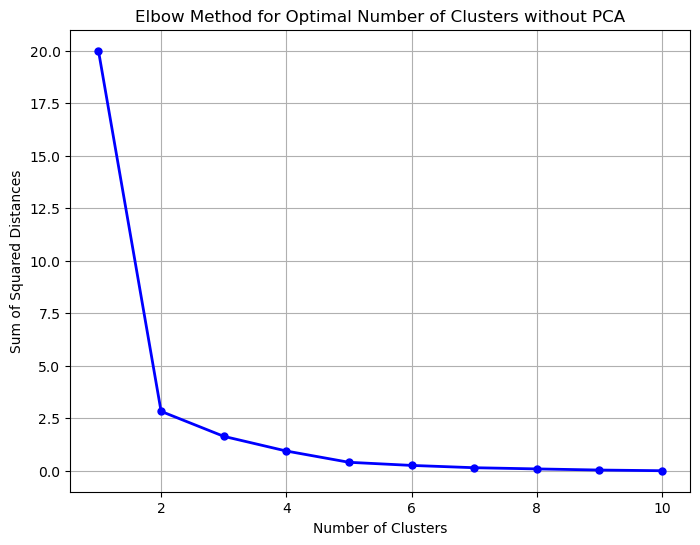


Elbow Method with PCA


/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dwu/mambaforge/envs/ml_portfolio/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1

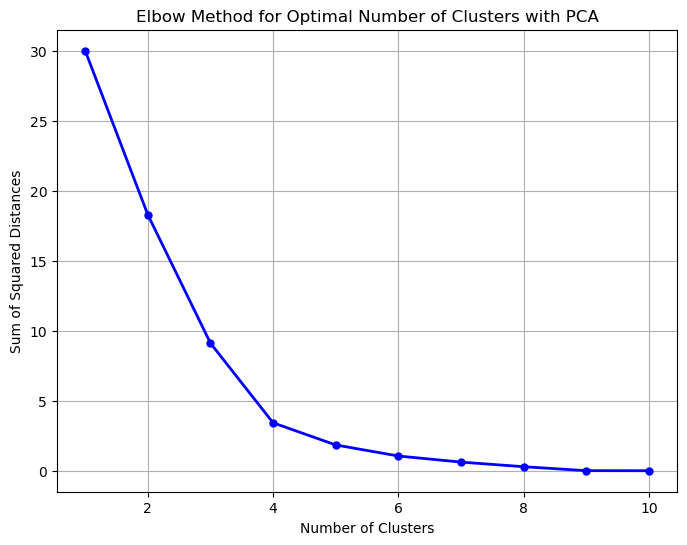

In [1]:
#Since dataset has been created, init is set to false
InitDataset.create_econ_data(init=False)
InitDataset.create_merged_stock_data(init=False)
InitDataset.create_adj_closed_price(init=False)

## Data Exploration

In [ ]:
# Load the dataset for the first ticker
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_csv(r'dataset/stock_data/AAPL_data.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
stock_data.head()

In [ ]:
# Check the shape of the dataset
print(stock_data.shape)

# Check the start and end date of the dataset
print(stock_data.index.min())
print(stock_data.index.max())

# Duration of stock data
duration = stock_data.index.max() - stock_data.index.min()
print(duration)

In [ ]:
# Data Cleaning and Sanity Check
# Check for missing values
print(stock_data.isnull().sum(), '\n')
# Check for duplicate values
print(stock_data.duplicated().sum())
# Describe the dataset
print(stock_data.describe())

# Initial Data Visualization

In [ ]:
# Plot the adjusted close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Adjusted Close Price of AAPL')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.plot(stock_data['Adj Close'])
plt.show()

In [ ]:
# KDE plot of the adjusted close price
plt.figure(figsize=(10,6))
sns.kdeplot(stock_data['Adj Close'], shade=True)
plt.title('KDE plot of Adjusted Close Price')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Density')
plt.show()

# Models

In [ ]:
# Load the dataset
test_data, train_data, index_data = InitDataset.get_test_train_data()

In [ ]:
portfolio_returns = train_data.pct_change()
covariance = portfolio_returns.cov()*252
# Heatmap of the covariance matrix
plt.figure(figsize=(10,6))
sns.heatmap(covariance, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix')
plt.show()

In [ ]:
# Allocate equal weights to all stocks

weights = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
portfolio_variance = np.transpose(weights) @ covariance @ weights
print(f'Portfolio Variance: {portfolio_variance}')

In [ ]:
# Calculate the portfolio volatility

windowed = portfolio_returns.rolling(30)
volatility = windowed.std() * np.sqrt(252)
volatility.plot(figsize=(10,6))
plt.title('Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

In [ ]:
# Plot the adjusted close price
train_data.plot(title='Adjusted Close Price')
plt.show()

In [ ]:
# Calculate the daily returns
asset_returns = train_data.pct_change()
portfolio_returns = asset_returns@weights

# Plot the daily returns
portfolio_returns.plot().set_ylabel('Daily Returns')
plt.title('Portfolio Daily Returns')
plt.show()

In [ ]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed= portfolio_returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the portfolio volatility
volatility_series.plot().set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

In [ ]:
# Convert daily returns to quarterly average returns
quarterly_returns = portfolio_returns.resample('MS').mean().dropna()
quarterly_returns.plot().set_ylabel("Quarterly Returns")
plt.title('Portfolio Quarterly Returns')
plt.show()

In [ ]:
# Transform daily portfolio_returns returns into quarterly minimum returns
quarterly_min_returns = portfolio_returns.resample('Q').min().dropna()
quarterly_min_returns.plot().set_ylabel("Quarterly Minimum Returns")
plt.title('Portfolio Quarterly Minimum Returns')
plt.show()

## Kmeans - Volatility (Daily)

In [ ]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.volatility_feature_engineering()

cluster_range = range(3, 10)
kmeans.volatility_clustering_without_pca(range_n_clusters=cluster_range)
kmeans.plot_elbow_method()
kmeans.plot_metrics_without_pca()
kmeans.volatility_clustering_with_pca(range_n_clusters=cluster_range)
kmeans.plot_elbow_method()
kmeans.plot_metrics_pca()

kmeans.plot_metrics()

## Kmeans - Quarterly data


In [ ]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.gdp_quarterly_feature_engineering()

kmeans.gdp_quarterly_clustering_without_pca()
kmeans.gdp_quarterly_clustering_pca()


## Kmeans Balance dataset

In [ ]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.quarterly_feature_engineering(n_clusters=4)





## Kmeans - Economic data 

In [ ]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_econ_data()
indicators = ['REAINTRATREARAT10Y', 'MEDCPIM158SFRBCLE', 'PSAVERT', 'UNRATE']
kmeans.economic_indicator_clustering_without_pca(indictors=indicators)
kmeans.economic_indicator_clustering_pca(indictors=indicators)

# ARMIA visualizations

In [ ]:
# Check for stationarity using the Augmented Dickey-Fuller test
models = []
for col in train_data.columns:
    print(col)
    adj_closed = train_data[col]
    # columns_except_first = stock_data.iloc[:, 1:]
    arima = MyARIMA(adj_closed)
    models.append((arima,col))
    arima.check_stationarity(adj_closed)

Looking at the Rolling Mean and Original Data, We are deciding whether the time series can be captured by a normal time series or 
it needs to be converted to logarithm

In [ ]:
convert_log = {'AAPL' : True,'AMD' : True,'AMZN': False,'F': True,'GOOG' : False,'INTC':False,'JPM':False,'MSFT':False, 'MS': True,
               'NVDA':True, 'TSLA':True,'VOO':False}

The plot depicts increasing mean and standard deviation. Additionally p-value > 0.05. Hence, the timeseries is not stationary.

Additionally, the test statistics exceeds the critical values. As a result, the data is nonlinear.

### Make the time-series stationary

### ACF and PACF plots 

In [ ]:
shift = 1
for arima,col in models:
    print(col)
    data = arima.time_series_data
    if convert_log[col]:
        data = arima.log_data(data)
    diff_data = arima.difference_data(data,shift)[1:]
    arima.check_stationarity(diff_data)
    arima.acf_pacf_plots(diff_data)

All p-values are well below the threshold, so we can consider the difference time series to be stationary. So the degree d of ARIMA(p,d,q) for all stocks is 1.

For p and q values, we will use the auto arima function to get the parameters for the ARIMA model

In [ ]:
forecasted_data = test_data.copy()
N = len(forecasted_data)
for arima,col in models:
    print(col)
    data = arima.time_series_data
    if convert_log[col]:
        data = arima.log_data(data)
    arima.fit_arima_parameters(data)
    if convert_log[col]:
        forecasted_data[col] = np.exp(arima.forecast(data,N))
    else:
        forecasted_data[col] = arima.forecast(data,N)


In [ ]:
mpt = MPTOptimizer()
l = list(test_data.columns)

In [ ]:
arima_allocs = mpt.optimize_portfolio(forecasted_data)
print("Forecasted Data Allocation")
for val, ticker in zip(arima_allocs, l):
    print(ticker + ": " + str(round(val,3)))

In [ ]:
mpt_allocs = mpt.optimize_portfolio(train_data)
print("MyOptimizer's Data Allocation")
for val, ticker in zip(mpt_allocs, l):
    print(ticker + ": " + str(round(val,3)))

In [ ]:
mean_arima, std_arima, cr_arima, sr_arima = utils.sharpe_ratio_metrics(test_data,arima_allocs)
treynor_arima,beta_arima,alpha_arima = utils.treynor_ratio_metrics(test_data,arima_allocs,index_data)
print("ARIMA Metrics")
print("Mean: " + str(mean_arima))
print("Std Dev: " + str(std_arima))
print("Calculated Risk: " + str(cr_arima))
print("Sharpe Ratio: " + str(sr_arima))
print("Treynor Ratio: " + str(treynor_arima))
print("Beta: " + str(beta_arima))
print("Alpha: " + str(alpha_arima))

In [ ]:
mean_mpt, std_mpt,cr_mpt, sr_mpt = utils.sharpe_ratio_metrics(test_data,mpt_allocs)
treynor_mpt,beta_mpt,alpha_mpt = utils.treynor_ratio_metrics(test_data,mpt_allocs,index_data)
print("MyOptimizer Metrics")
print("Mean: " + str(mean_mpt))
print("Std Dev: " + str(std_mpt))
print("Calculated Risk: " + str(cr_mpt))
print("Sharpe Ratio: " + str(sr_mpt))
print("Treynor Ratio: " + str(treynor_mpt))
print("Beta: " + str(beta_mpt))
print("Alpha: " + str(alpha_mpt))



In [ ]:
kmeans_allocs = [0,0,0,0,0,0,1.0/3,0,0,1.0/3,0,1.0/3]

In [ ]:
mean_kmeans, std_kmeans,cr_kmeans, sr_kmeans = utils.sharpe_ratio_metrics(test_data,kmeans_allocs)
treynor_kmeans,beta_kmeans,alpha_kmeans = utils.treynor_ratio_metrics(test_data,kmeans_allocs,index_data)

print("KMeans Metrics")
print("Mean: " + str(mean_kmeans))
print("Std Dev: " + str(std_kmeans))
print("Calculated Risk: " + str(cr_kmeans))
print("Sharpe Ratio: " + str(sr_kmeans))
print("Treynor Ratio: " + str(treynor_kmeans))
print("Beta: " + str(beta_kmeans))
print("Alpha: " + str(alpha_kmeans))


In [ ]:
kmeans_pca_allocs = [0,0,0,0,0,0,1.0/4,0,0,1.0/4,1.0/4,1.0/4]

In [ ]:
mean_kmeans_pca, std_kmeans_pca,cr_kmeans_pca, sr_kmeans_pca = utils.sharpe_ratio_metrics(test_data,kmeans_pca_allocs)
treynor_kmeans_pca,beta_kmeans_pca,alpha_kmeans_pca = utils.treynor_ratio_metrics(test_data,kmeans_pca_allocs,index_data)


print("KMeans w PCA Metrics")
print("Mean: " + str(mean_kmeans_pca))
print("Std Dev: " + str(std_kmeans_pca))
print("Calculated Risk: " + str(cr_kmeans_pca))
print("Sharpe Ratio: " + str(sr_kmeans_pca))
print("Treynor Ratio: " + str(treynor_kmeans_pca))
print("Beta: " + str(beta_kmeans_pca))
print("Alpha: " + str(alpha_kmeans_pca))